In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generating figures from metrics

## Baseline

In [55]:
df = pd.read_csv("../results/baseline_gan/metrics.csv")

# clean
df = df.sort_values("epoch").reset_index(drop=True)
df["fid"] = pd.to_numeric(df["fid"], errors="coerce")
df = df.dropna(subset=["fid"])

fid = df["fid"]
epoch = df["epoch"]
change_mask = fid.ne(fid.shift(1)) # fid changes
change_epochs = epoch[change_mask].to_numpy()
change_fids = fid[change_mask].to_numpy()

# do exponential moving smoothign
ema_span = max(5, min(20, len(df)//10 if len(df) >= 50 else 10))
df["fid_ema"] = df["fid"].ewm(span=ema_span, adjust=False).mean()

stabilization_epoch = None
monotone_after_stab = False
if len(change_fids) >= 2:
    diffs = np.diff(change_fids)
    for i in range(len(change_fids)):
        future_diffs = np.diff(change_fids[i:])
        if np.all(future_diffs <= 1e-12):
            stabilization_epoch = int(change_epochs[i])
            monotone_after_stab = True
            break

# plot
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(df["epoch"], df["fid"], linewidth=1.5, label="FID")
ax.plot(df["epoch"], df["fid_ema"], linewidth=2.0, alpha=0.6, label=f"EMA (span={ema_span})")

# markers
for e in change_epochs:
    ax.axvline(e, linewidth=1.0, alpha=0.15)

# change points
max_labels = 12
if len(change_epochs) <= max_labels:
    label_epochs = change_epochs
    label_fids = change_fids

else:
    idxs = np.unique(np.linspace(0, len(change_epochs)-1, max_labels).astype(int))
    label_epochs = change_epochs[idxs]
    label_fids = change_fids[idxs]

for e, f in zip(label_epochs, label_fids):
    ax.scatter([e], [f], s=18)
    ax.annotate(f"{f:.1f}", xy=(e, f), xytext=(-10, -10), textcoords="offset points", ha="left", va="top",
        fontsize=8, alpha=0.9)


ax.set_title("")
ax.set_xlabel("Epoch")
ax.set_ylabel("FID score")
ax.legend(frameon=False, fontsize='large')
ax.grid(True, alpha=0.2)
plt.ylim((75,350))

plt.savefig("../figures/baseline_images/fid_vs_epochs.png", dpi=300, bbox_inches='tight')
plt.close()

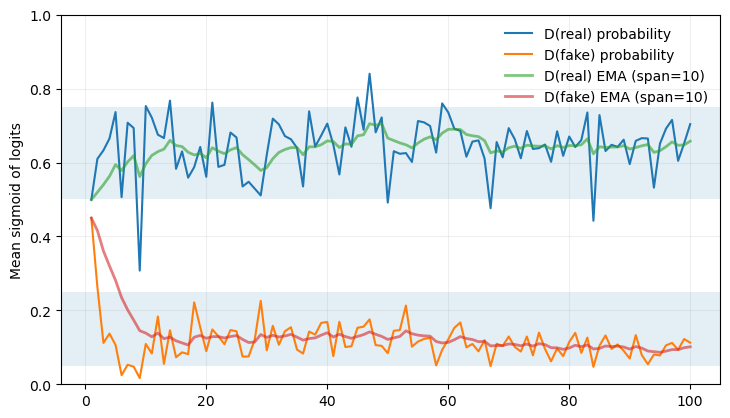

In [54]:
# load
df = pd.read_csv("../results/baseline_gan/metrics.csv")
df = df.sort_values("epoch").reset_index(drop=True)

for col in ["d_real_prob", "d_fake_prob"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=["d_real_prob", "d_fake_prob"])

# smoothing
ema_span = max(5, min(20, len(df)//10 if len(df) >= 50 else 10))
df["d_real_ema"] = df["d_real_prob"].ewm(span=ema_span, adjust=False).mean()
df["d_fake_ema"] = df["d_fake_prob"].ewm(span=ema_span, adjust=False).mean()

# plot
fig, ax = plt.subplots(figsize=(8.5, 4.8))

# healthy
ax.axhspan(0.5, 0.75, alpha=0.12)
# fake
ax.axhspan(0.05, 0.25, alpha=0.12)

ax.plot(df["epoch"], df["d_real_prob"], linewidth=1.5, label="D(real) probability")
ax.plot(df["epoch"], df["d_fake_prob"], linewidth=1.5, label="D(fake) probability")
ax.plot(df["epoch"], df["d_real_ema"], linewidth=2.0, alpha=0.6, label=f"D(real) EMA (span={ema_span})")
ax.plot(df["epoch"], df["d_fake_ema"], linewidth=2.0, alpha=0.6, label=f"D(fake) EMA (span={ema_span})")

ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("Mean sigmoid of logits")
ax.set_ylim(0.0, 1.0)
ax.grid(True, alpha=0.2)
ax.legend(frameon=False)


plt.savefig("../figures/baseline_images/disc_two_rivers.png", dpi=300, bbox_inches = 'tight')
plt.show()
plt.close()
